In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (normalize and reshape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create batches and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [3]:
# Define the Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Instantiate the generator
generator = build_generator()


In [4]:
# Define the Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Instantiate the discriminator
discriminator = build_discriminator()


In [5]:
# Define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [6]:
# Training step for the GAN
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for consistent image generation
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)


In [7]:
# Helper function to save generated images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

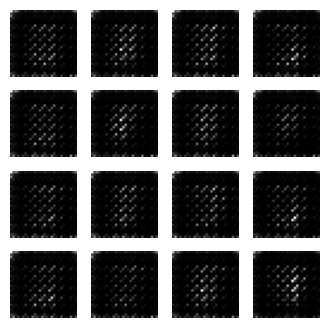

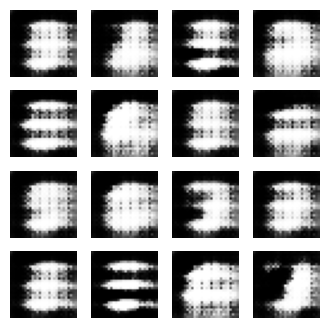

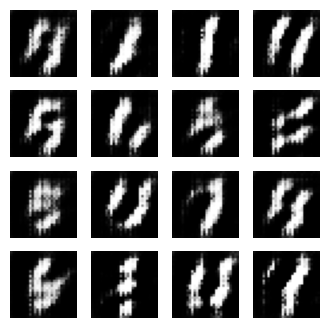

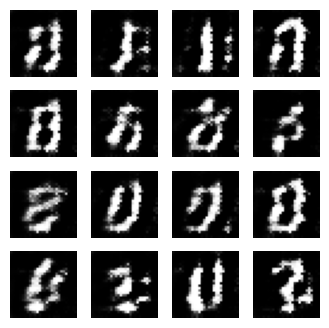

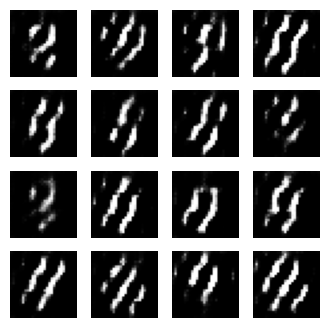

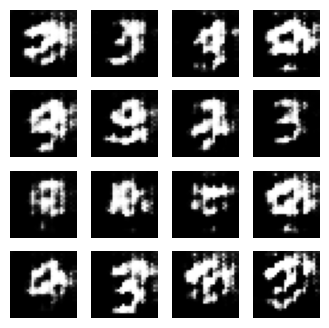

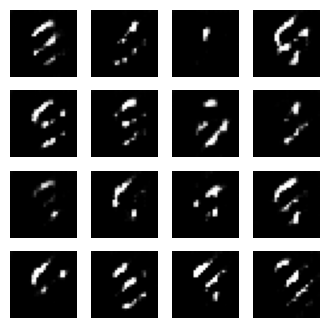

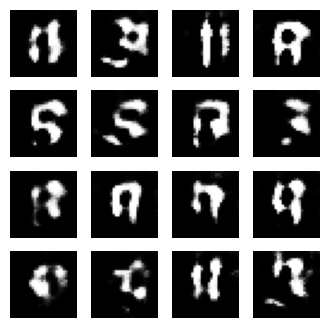

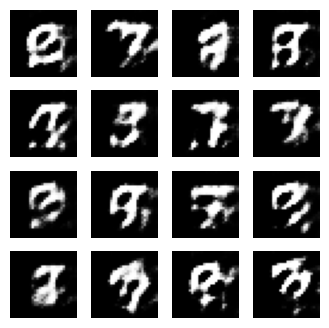

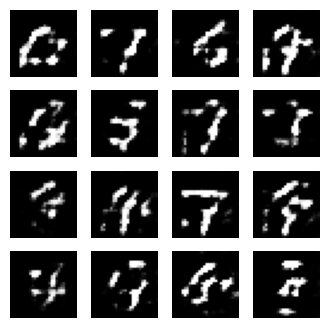

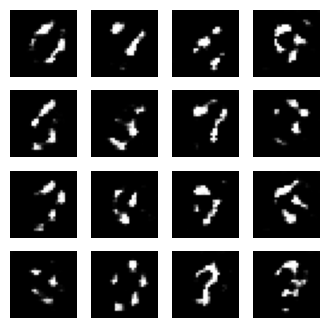

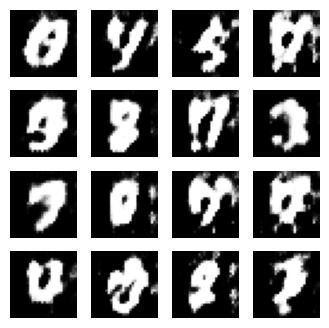

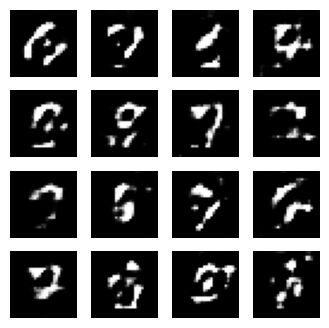

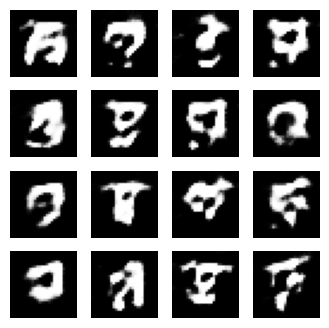

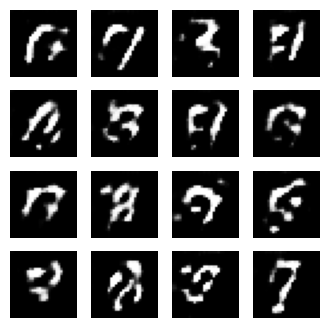

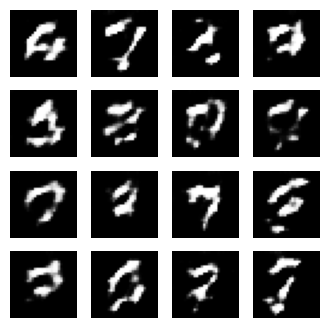

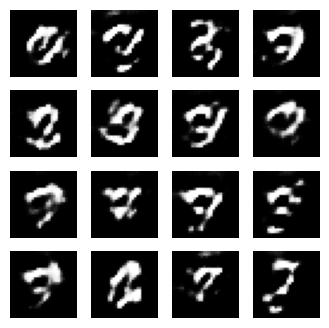

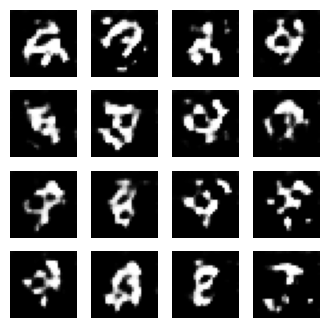

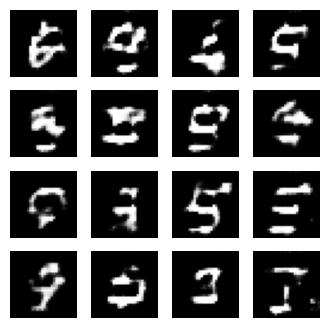

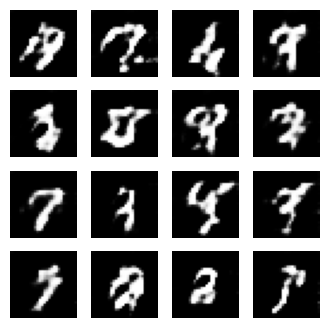

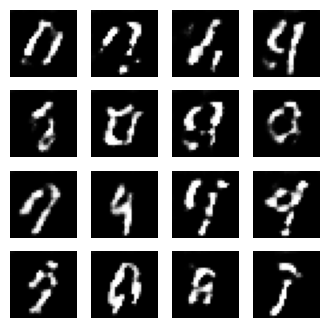

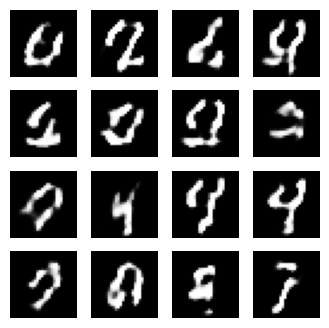

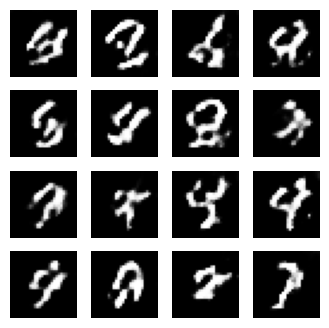

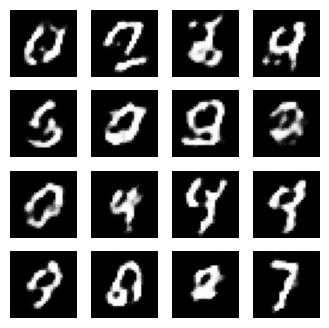

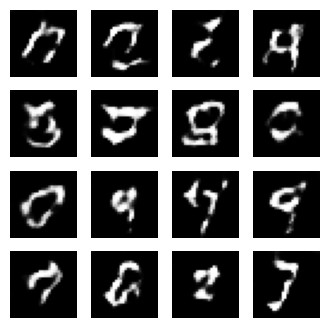

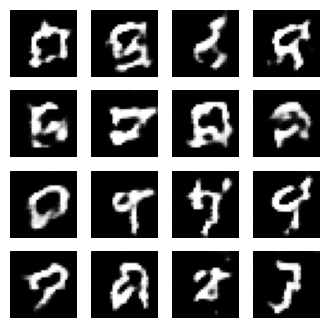

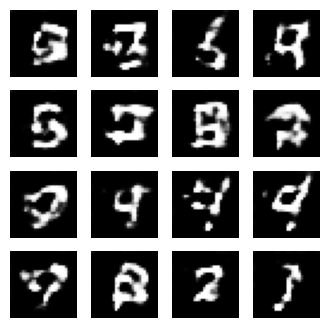

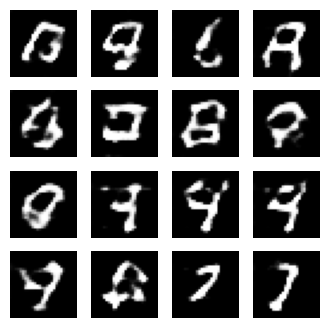

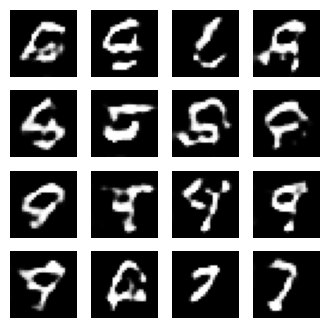

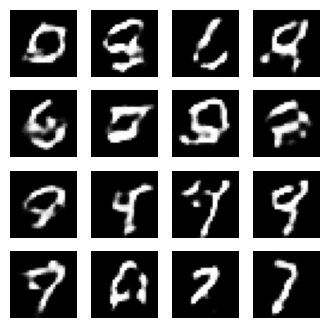

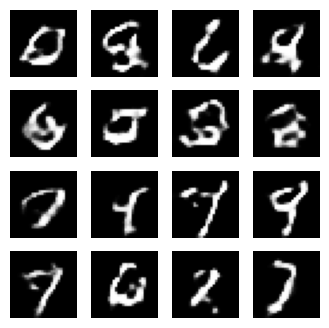

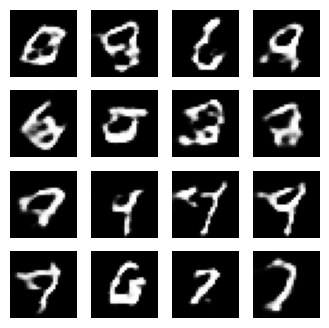

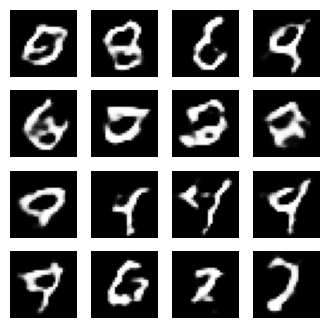

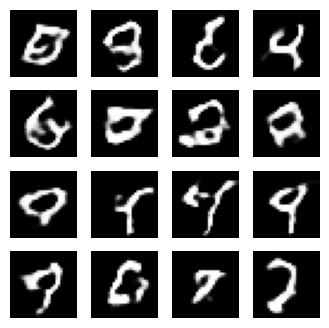

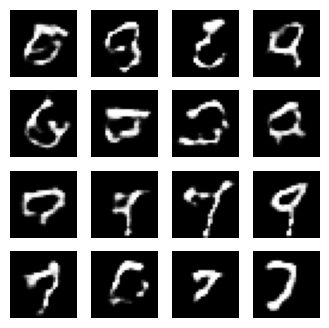

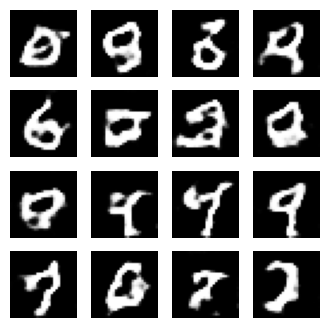

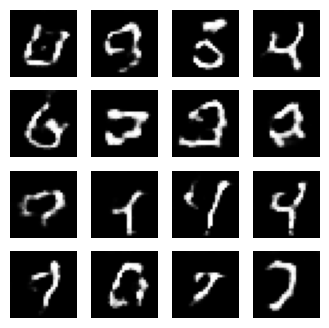

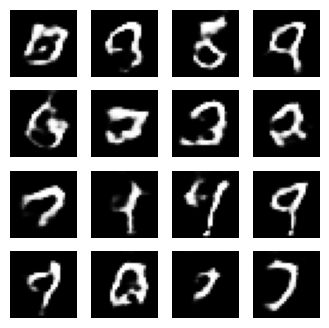

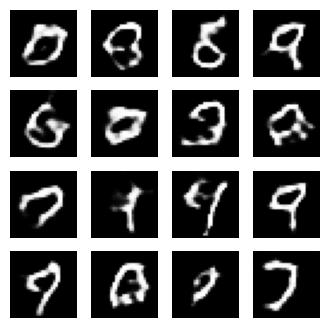

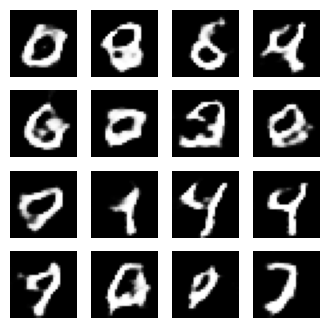

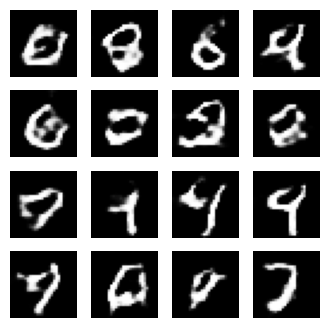

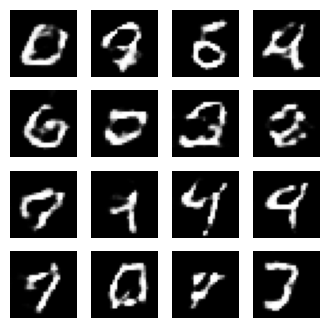

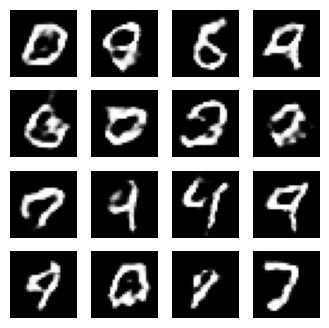

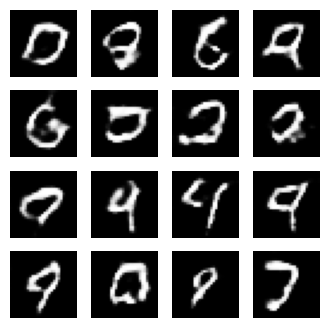

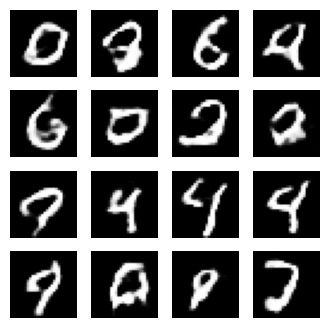

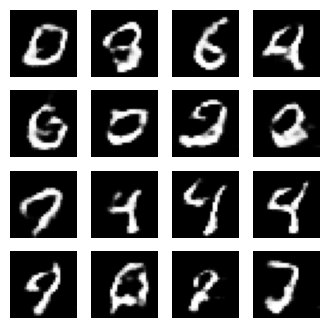

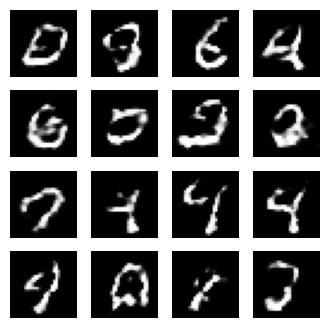

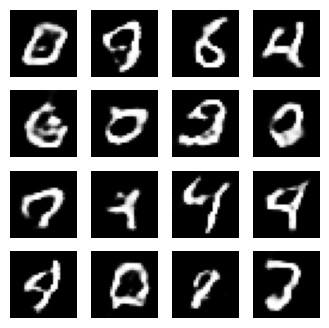

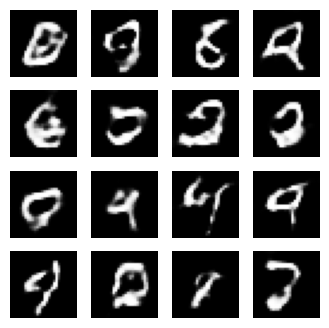

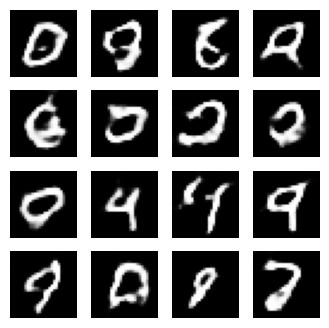

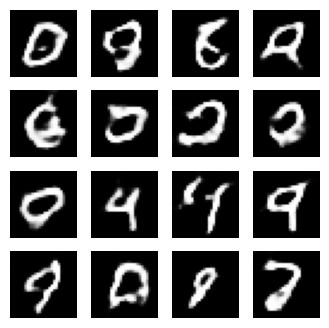

In [8]:
# Start training
train(train_dataset, EPOCHS)

In [9]:
# Save the generator and discriminator models after training
def save_models(generator, discriminator, epoch):
    generator.save(f'generator_epoch_{epoch}.h5')
    discriminator.save(f'discriminator_epoch_{epoch}.h5')

# Save models at the end of training
save_models(generator, discriminator, EPOCHS)


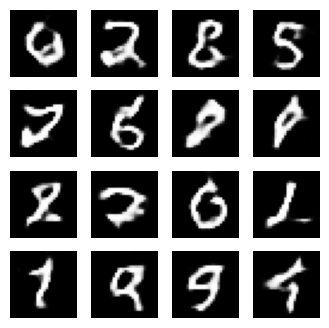

In [10]:
# Load the generator model and test it by generating images
def test_generator(model_path, noise_dim=100, num_examples=16):
    # Load the trained generator model
    generator = tf.keras.models.load_model(model_path)
    
    # Generate random noise for testing
    random_noise = tf.random.normal([num_examples, noise_dim])
    
    # Generate images
    generated_images = generator(random_noise, training=False)
    
    # Display generated images
    fig = plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

# Test the generator using saved model
test_generator('generator_epoch_50.h5')

In [11]:
# Monitor discriminator accuracy
def calculate_discriminator_accuracy(real_images, fake_images):
    real_output = discriminator(real_images, training=False)
    fake_output = discriminator(fake_images, training=False)

    real_acc = tf.reduce_mean(tf.cast(tf.greater(real_output, 0), tf.float32)).numpy()
    fake_acc = tf.reduce_mean(tf.cast(tf.less(fake_output, 0), tf.float32)).numpy()

    print(f"Discriminator Real Accuracy: {real_acc:.2f}, Fake Accuracy: {fake_acc:.2f}")
    return real_acc, fake_acc

# Example usage during training
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generated_images = generator(noise, training=False)
calculate_discriminator_accuracy(train_images[:BATCH_SIZE], generated_images)

Discriminator Real Accuracy: 0.72, Fake Accuracy: 0.54


(0.72265625, 0.53515625)

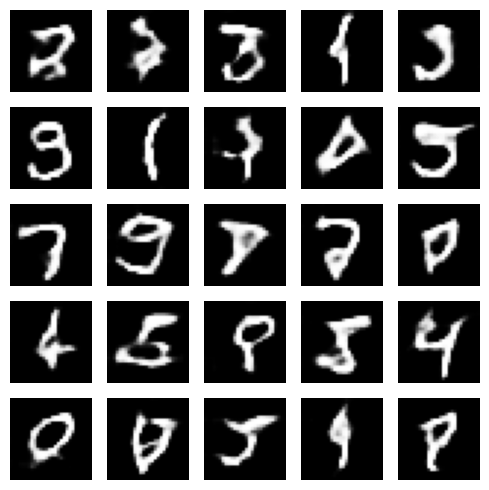

In [13]:
# Visualize the diversity of generated images
def visualize_image_grid(generator, num_rows=5, num_cols=5, noise_dim=100):
    noise = tf.random.normal([num_rows * num_cols, noise_dim])
    generated_images = generator(noise, training=False)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(generated_images[i * num_cols + j, :, :, 0] * 127.5 + 127.5, cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize diversity in generated images
visualize_image_grid(generator)